In [1]:
from hyperopt import hp
from hyperopt.pyll.base import scope

import DatasetRun
from KNNClassifier import KNNClassifier
from KMeans import KMeans
import Metrics

In [2]:
device = DatasetRun.get_device()

Device used: cuda


Sample run

In [5]:
metric = Metrics.MahalanobisMetric(shrinkage=True, gamma_1=1, gamma_2=1, normalization=True)
kmeans = KMeans(n_clusters=30, max_iter=1)
clf = KNNClassifier(n_neighbors=3,
                    metric=metric,
                    tukey_lambda=0.5,
                    kmeans=kmeans,
                    device=device)
_ = DatasetRun.train(clf, 6, 'tasks2', verbose=True)

task 0: (time: 3.318)
Paper accuracy: 83.560; Mahalanobis knn accuracy: 83.240
task 1: (time: 3.063)
Paper accuracy: 76.517; Mahalanobis knn accuracy: 75.033
task 2: (time: 3.808)
Paper accuracy: 72.129; Mahalanobis knn accuracy: 70.386
task 3: (time: 4.347)
Paper accuracy: 67.662; Mahalanobis knn accuracy: 66.050
task 4: (time: 5.324)
Paper accuracy: 64.533; Mahalanobis knn accuracy: 62.722
task 5: (time: 6.467)
Paper accuracy: 62.280; Mahalanobis knn accuracy: 60.740


## Grid search

In [11]:
def train_grid(params):
    n_neighbors = params['n_neighbors']
    gamma_1 = params['gamma_1']
    gamma_2 = params['gamma_2']
    tukey_lambda = params['tukey_lambda']
    n_tasks = params['n_tasks']
    metric = Metrics.MahalanobisMetric(shrinkage=True, gamma_1=gamma_1, gamma_2=gamma_2, normalization=True)
    return -DatasetRun.train(n_neighbors, metric, tukey_lambda, device, n_tasks, 'tasks2', verbose=False)[-1]

search_space = {
    'n_neighbors': scope.int(hp.quniform('n_neighbors', 1, 20, 1)),
    'gamma_1': hp.uniform('gamma_1', 0.0001, 3.0),
    'gamma_2': hp.uniform('gamma_2', 0.0001, 3.0),
    'tukey_lambda': hp.uniform('tukey_lambda', 0, 5.0),
    'n_tasks': 4  # Training on only part of the tasks to hasten the process
}

trials, best = DatasetRun.grid_search(train_grid, search_space, 250)

print("Best hyperparameters:", best)

100%|██████████| 250/250 [6:42:47<00:00, 96.67s/trial, best loss: -0.622875] 
Best hyperparameters: {'gamma_1': 0.5305692362856793, 'gamma_2': 2.6900606882583644, 'n_neighbors': 1.0, 'tukey_lambda': 0.4885856783807092}


plot accuracy over trials (to check how well did the grid search work)

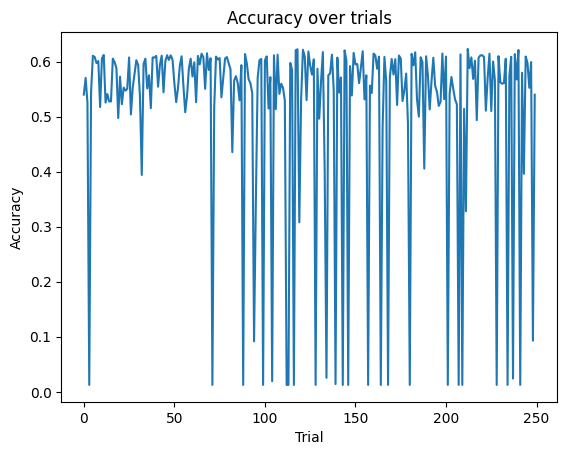

In [13]:
DatasetRun.plot_accuracy_trials(trials)

plot accuracies against hyperparameters' values 

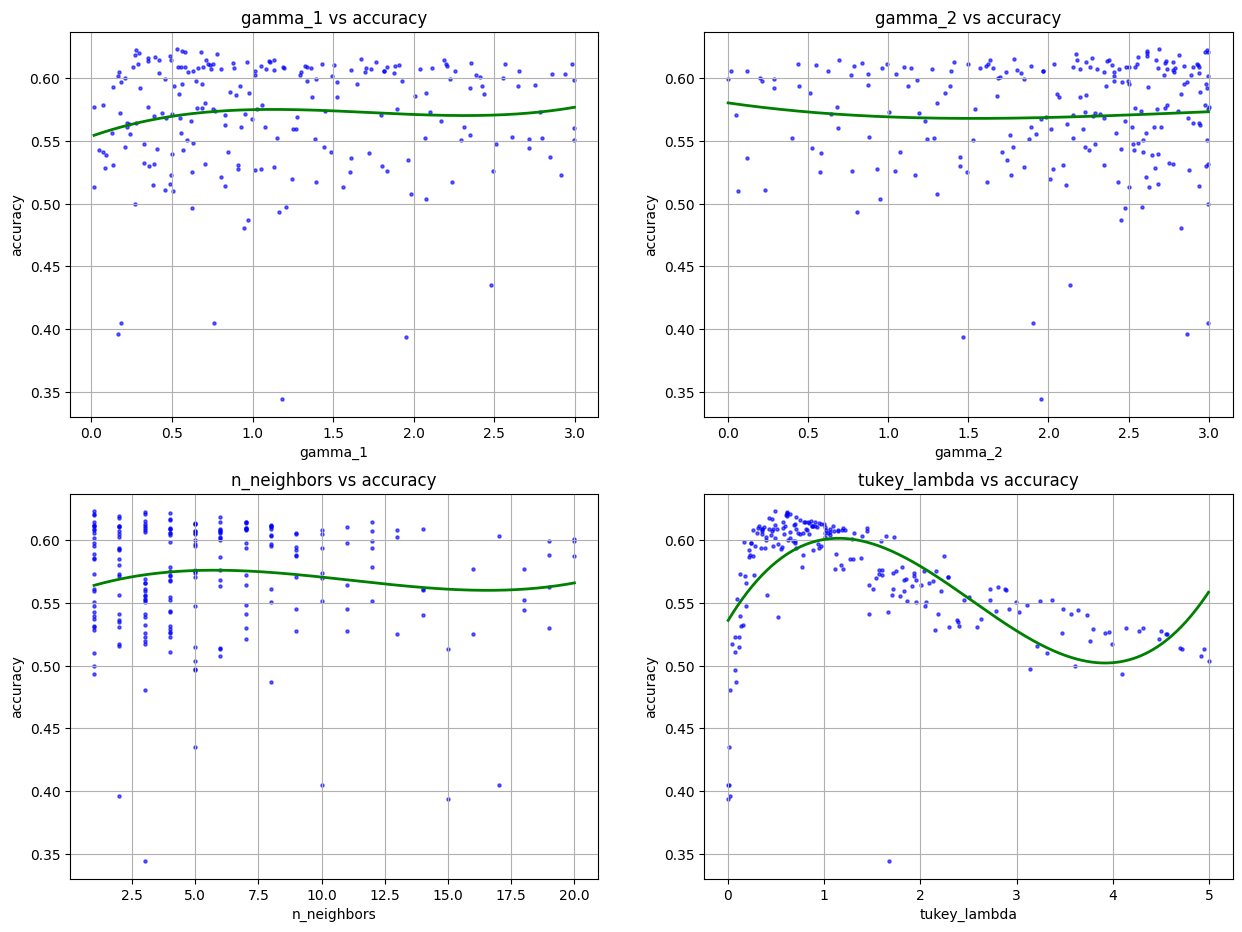

In [43]:
DatasetRun.plot_hyperparameters(trials, 2, smooth=3, ylim=True)

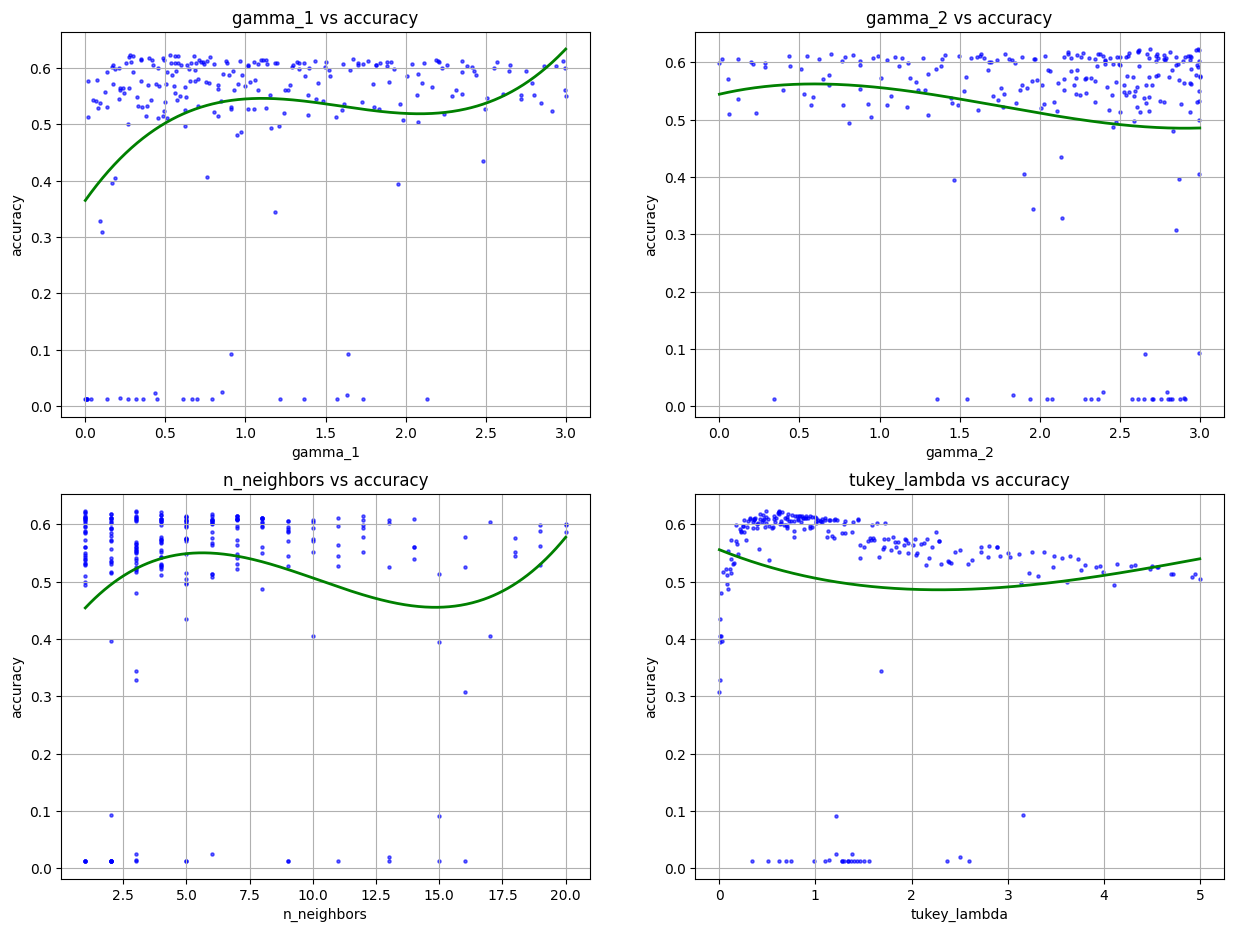

In [45]:
DatasetRun.plot_hyperparameters(trials, 2, smooth=10, ylim=False)

In [47]:
DatasetRun.print_results(trials, 50)

Top 50 Results:
Trial 1:
  Accuracy: 0.6229
  Parameters:
    gamma_1: 0.5306
    gamma_2: 2.6901
    n_neighbors: 1.0000
    tukey_lambda: 0.4886
------------------------------
Trial 2:
  Accuracy: 0.6222
  Parameters:
    gamma_1: 0.2779
    gamma_2: 2.9886
    n_neighbors: 3.0000
    tukey_lambda: 0.6193
------------------------------
Trial 3:
  Accuracy: 0.6214
  Parameters:
    gamma_1: 0.5614
    gamma_2: 2.6176
    n_neighbors: 4.0000
    tukey_lambda: 0.6191
------------------------------
Trial 4:
  Accuracy: 0.6209
  Parameters:
    gamma_1: 0.6788
    gamma_2: 2.9976
    n_neighbors: 1.0000
    tukey_lambda: 0.6495
------------------------------
Trial 5:
  Accuracy: 0.6205
  Parameters:
    gamma_1: 0.5817
    gamma_2: 2.9757
    n_neighbors: 3.0000
    tukey_lambda: 0.6192
------------------------------
Trial 6:
  Accuracy: 0.6201
  Parameters:
    gamma_1: 0.2984
    gamma_2: 2.6139
    n_neighbors: 1.0000
    tukey_lambda: 0.6091
------------------------------
Trial 7:
  A